In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [2]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [3]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')


In [4]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [5]:
dftrain

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
...,...,...,...,...,...,...,...,...,...
622,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
623,male,25.0,0,0,7.0500,Third,unknown,Southampton,y
624,female,19.0,0,0,30.0000,First,B,Southampton,y
625,female,28.0,1,2,23.4500,Third,unknown,Southampton,n


In [6]:
dftrain.loc[23]

sex                        male
age                        40.0
n_siblings_spouses            0
parch                         0
fare                    27.7208
class                     First
deck                    unknown
embark_town           Cherbourg
alone                         y
Name: 23, dtype: object

In [7]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

<AxesSubplot:>

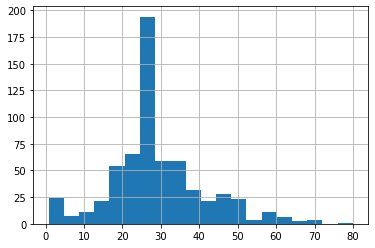

In [8]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

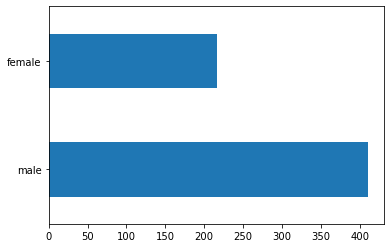

In [9]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

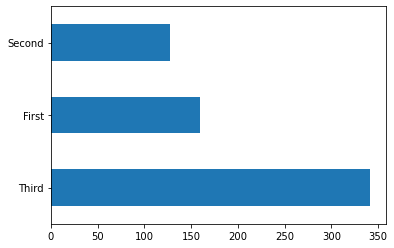

In [10]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

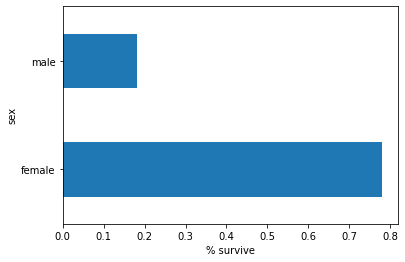

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [12]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [13]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [14]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'First' b'Third' b'Third' b'Third' b'Second' b'Third' b'Third' b'Third'
 b'Second' b'Third']

A batch of Labels: [1 0 0 0 1 1 0 0 0 0]


In [16]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[47.],
       [26.],
       [28.],
       [17.],
       [50.],
       [36.],
       [17.],
       [39.],
       [28.],
       [28.]], dtype=float32)

In [17]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [18]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7765151, 'accuracy_baseline': 0.625, 'auc': 0.8333945, 'auc_precision_recall': 0.78488743, 'average_loss': 0.49286866, 'label/mean': 0.375, 'loss': 0.48308352, 'precision': 0.7380952, 'prediction/mean': 0.315179, 'recall': 0.6262626, 'global_step': 200}


In [19]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [20]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7462121, 'accuracy_baseline': 0.625, 'auc': 0.84367925, 'auc_precision_recall': 0.78979224, 'average_loss': 0.4792061, 'label/mean': 0.375, 'loss': 0.47356796, 'precision': 0.6481481, 'prediction/mean': 0.4315707, 'recall': 0.7070707, 'global_step': 200}


In [21]:
result

{'accuracy': 0.7462121,
 'accuracy_baseline': 0.625,
 'auc': 0.84367925,
 'auc_precision_recall': 0.78979224,
 'average_loss': 0.4792061,
 'label/mean': 0.375,
 'loss': 0.47356796,
 'precision': 0.6481481,
 'prediction/mean': 0.4315707,
 'recall': 0.7070707,
 'global_step': 200}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\91949\AppData\Local\Temp\tmph_p9zsfk\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

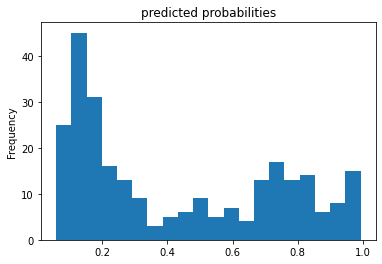

In [22]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

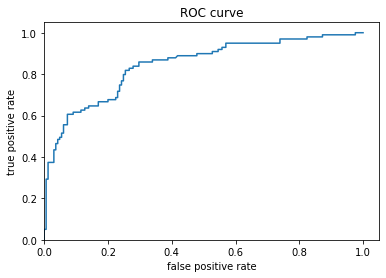

In [23]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)